In [1]:
from catboost import CatBoostRegressor

In [2]:
import numpy as np
import pandas as pd

In [3]:
from pandas.api.types import is_object_dtype

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.ensemble import IsolationForest

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import category_encoders as ce

In [6]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

In [7]:
TARGET_COL = 'price'

In [8]:
TRAIN_SZ = 0.8
SEED_SPLITTING = 42

### Load data

In [9]:
data_path = '../data/cars_dataset_new_v2.csv'

In [10]:
cars_df = pd.read_csv(data_path, index_col=0)
n_rows, _ = cars_df.shape
print(f'DF shape: {cars_df.shape}')

cars_df['price'] = cars_df['price'] / 1e6  # NORMALIZE PRICE TO MILLIONS!

pd.set_option('display.max_columns', None)
cars_df.sample(3)

DF shape: (22702, 29)


,box,drive_unit,seats,doors,country,volume,mileage,price,year,car_type,drive,boost_type,width,diemeter,length,car_class,height,fuel,torque,valves_per_cylinder,clearance,maximum_speed,transmissions,full_weight,compression_ratio,consumption,restyling,trunk_volume_max,trunk_volume_min
14010,automatic,full,5.0,5.0,South Korea,2.2,41940.0,2.780,2018.0,SUV,full,turbocharging,1890.0,85.4,4800.0,J,1685.0,diesel,441.0,4.0,185.0,203.0,8.0,2620.0,16.000000,6.5,1.0,660.0,1732.0
22213,robot,front,7.0,4.0,German,2.0,265000.0,1.420,2011.0,Minivan,front,turbocharging,1904.0,0.0,5292.0,M,1990.0,diesel,340.0,4.0,201.0,173.0,7.0,3000.0,11.149437,8.0,1.0,0.0,0.0
7068,automatic,full,5.0,5.0,Japan,3.5,105000.0,1.345,2009.0,SUV,full,no,1885.0,94.0,4770.0,J,1725.0,AI-95,346.0,4.0,180.0,200.0,6.0,2545.0,10.800000,10.6,0.0,496.0,0.0


In [11]:
cat_cols = []
num_cols = []

for column_name in cars_df.columns:  # find all categorical and numerical columns
    if not column_name == TARGET_COL:
        if is_object_dtype(cars_df[column_name]):
            cat_cols.append(column_name)
        else:
            num_cols.append(column_name)

print(f'Categorical ({len(cat_cols)}):')
print(*cat_cols, sep=', ', end='\n\n')
print(f'Numerical ({len(num_cols)}):')
print(*num_cols, sep=', ')

Categorical (8):
box, drive_unit, country, car_type, drive, boost_type, car_class, fuel

Numerical (20):
seats, doors, volume, mileage, year, width, diemeter, length, height, torque, valves_per_cylinder, clearance, maximum_speed, transmissions, full_weight, compression_ratio, consumption, restyling, trunk_volume_max, trunk_volume_min


In [12]:
def drop_all_from_list(lst, elements):
    for elem in elements:
        if elem in lst:
            lst.remove(elem)

def add_all_to_list(lst, elements):
    for elem in elements:
        if elem not in lst:
            lst.append(elem)

In [51]:
cat_num_cols = ['seats', 'doors', 'valves_per_cylinder', 'restyling']  # are categorical!

for cat_num_name in cat_num_cols:
    if cat_num_name == 'valves_per_cylinder':  # saving order
        cars_df[cat_num_name] = cars_df[cat_num_name].apply(lambda x: int(x - 1) if x < 3.5 else int(x))
    cars_df[cat_num_name] = pd.to_numeric(cars_df[cat_num_name], downcast="integer")

drop_all_from_list(num_cols, cat_num_cols)
add_all_to_list(cat_cols, cat_num_cols)

In [53]:
cars_df.head()

,box,drive_unit,seats,doors,country,volume,mileage,price,year,car_type,drive,boost_type,width,diemeter,length,car_class,height,fuel,torque,valves_per_cylinder,clearance,maximum_speed,transmissions,full_weight,compression_ratio,consumption,restyling,trunk_volume_max,trunk_volume_min
0,automatic,full,5,5,German,2.9,0.0,12.9028,2020.0,SUV,full,turbocharging,1931.0,0.0,4817.0,J,1969.0,diesel,0.0,4,241.0,199.0,9.0,3150.0,15.5,9.8,0,667.0,1941.0
1,automatic,full,5,5,German,2.9,0.0,15.7095,2020.0,SUV,full,turbocharging,1931.0,82.0,4817.0,J,1969.0,diesel,700.0,4,241.0,210.0,9.0,3150.0,15.5,9.6,0,667.0,1941.0
2,automatic,full,5,5,German,4.0,15500.0,13.8900,2019.0,SUV,full,turbocharging,1931.0,83.0,4817.0,J,1969.0,AI-95,610.0,4,241.0,210.0,9.0,3150.0,10.5,12.1,0,667.0,1941.0
3,automatic,full,5,5,German,4.0,0.0,13.1160,2020.0,SUV,full,turbocharging,1931.0,83.0,4817.0,J,1969.0,AI-95,610.0,4,241.0,210.0,9.0,3150.0,10.5,12.1,0,667.0,1941.0
4,automatic,full,5,5,German,4.0,15297.0,11.4500,2019.0,SUV,full,turbocharging,1931.0,83.0,4817.0,J,1969.0,AI-95,610.0,4,241.0,210.0,9.0,3150.0,10.5,12.1,0,667.0,1941.0


In [54]:
print('Count NaN values in TRAIN:')
for column_name in cars_df.columns:  # count nan values by columns
    nans = cars_df[column_name].isna().sum()
    if nans > 0:  # if there is NaN's in column `column_name`
        print(f"\t{column_name + (25 - len(column_name)) * ' '}{nans}",end='')
        if column_name in cat_cols:
            print('\t(cat)')
        else:
            print('\t(num)')

Count NaN values in TRAIN:
	drive                    191	(cat)
	boost_type               283	(cat)
	car_class                221	(cat)
	fuel                     419	(cat)


### Data splitting

In [55]:
X = cars_df.drop(columns=[TARGET_COL])
y = cars_df[TARGET_COL]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=TRAIN_SZ, random_state=SEED_SPLITTING
)

print(f'Train size: {len(y_train)}')
print(f'Test size:  {len(y_test)}')

Train size: 18161
Test size:  4541


If we will normalize all numeric features before data splitting – it will be **small data leakage**!

Here we will try to normalize numerical features for `train data` only and then we will use the `train mean` and `variance` values to normalize features in test data!

In [57]:
def normalize_num_features_catboost(num_cols, X_train, X_test):
    num_train_means = {}
    num_train_vars = {}  # means and vars for numeric features calculated for train set!

    for num_column_name in num_cols:
        num_train_means[num_column_name] = X_train[num_column_name].mean()
        num_train_vars[num_column_name] = X_train[num_column_name].var(ddof=0)

        X_train[num_column_name] = (X_train[num_column_name] - num_train_means[num_column_name]) / num_train_vars[num_column_name]
            # normalize test set using the train set statistics
        X_test[num_column_name] = (X_test[num_column_name] - num_train_means[num_column_name]) / num_train_vars[num_column_name]
    
    return num_train_means, num_train_vars

In [58]:
num_train_means, num_train_vars = normalize_num_features_catboost(num_cols, X_train, X_test)

**We do not need** to somehow transform categorical features, `CatBoost` can deal even with `str`-type categorical features!

**But we need** to replace all `NaN`'s in categorical columns by the most frequent values in train set

In [59]:
def replace_nans_cat_features_catboost(cat_cols, X_train, X_test):
    cat_train_most_freq = {}

    for cat_column_name in cat_cols:
        cat_train_most_freq[cat_column_name] = cars_df[cat_column_name].mode().item()

        X_train[cat_column_name].fillna(cat_train_most_freq[cat_column_name], inplace=True)
            # use the column most frequent value to replace NaN's in test data
        X_test[cat_column_name].fillna(cat_train_most_freq[cat_column_name], inplace=True)
        
    return cat_train_most_freq

In [60]:
cat_train_most_freq = replace_nans_cat_features_catboost(cat_cols, X_train, X_test)

In [61]:
print('Count NaN values in TRAIN:')
for column_name in X_train.columns:  # count nan values by columns
    nans = X_train[column_name].isna().sum()
    if nans > 0:  # if there is NaN's in column `column_name`
        print(f"\t{column_name + (25 - len(column_name)) * ' '}{nans}",end='')
        if column_name in cat_cols:
            print('\t(cat)')
        else:
            print('\t(num)')

Count NaN values in TRAIN:


In [62]:
X_train.head()

,box,drive_unit,seats,doors,country,volume,mileage,year,car_type,drive,boost_type,width,diemeter,length,car_class,height,fuel,torque,valves_per_cylinder,clearance,maximum_speed,transmissions,full_weight,compression_ratio,consumption,restyling,trunk_volume_max,trunk_volume_min
19012,automatic,front,4,3,Sweden,0.062602,0.000009,-0.027270,Hatchback,front,no,-0.003270,0.012156,-0.002240,C,-0.004844,AI-95,-0.001630,4,-0.010189,0.022832,-0.398341,-0.001275,-0.143767,0.094384,0,-0.001049,0.000179
28088,mechanics,front,5,5,Japan,-0.302409,0.000004,-0.063949,Liftback,front,no,-0.003479,0.017887,0.000645,D,-0.005280,AI-95,-0.003595,4,-0.012262,0.008836,-0.398341,-0.001275,-0.059634,-0.537114,0,0.000183,0.000917
32541,automatic,front,5,4,Sweden,-0.302409,0.000005,-0.015043,Sedan,front,turbocharging,-0.005362,0.015977,0.000403,D,-0.004117,AI-95,0.001176,4,-0.003970,0.032830,-0.398341,-0.000543,-0.278380,0.184598,1,-0.000462,-0.000969
3271,automatic,rear,4,2,UK,3.895215,-0.000012,0.070542,Coupe,rear,turbocharging,0.013990,0.019797,0.004780,F,-0.002662,AI-95,0.021220,4,-0.010189,0.052824,1.436544,0.000002,-0.194247,0.515383,0,-0.000029,-0.000969
34551,automatic,rear,4,2,Japan,-0.302409,0.000005,-0.173988,Coupe,rear,no,-0.008710,0.015977,-0.000390,S,-0.018552,AI-95,-0.003314,4,-0.012262,-0.000005,-1.009969,0.000002,-0.194247,0.214669,0,-0.004553,-0.000969


### Trying CatBoost

In [72]:
CatBoostRegressor?

In [78]:
cat_model = CatBoostRegressor(
    iterations=10000,
    loss_function='MAE',
    random_seed=78,
    verbose=1000,
    cat_features=cat_cols  # categorical features
)

In [79]:
cat_model.fit(X_train, y_train)

0:	learn: 0.9559531	total: 11.2ms	remaining: 1m 52s
1000:	learn: 0.1907911	total: 7.79s	remaining: 1m 10s
2000:	learn: 0.1602065	total: 15.6s	remaining: 1m 2s
3000:	learn: 0.1478964	total: 23.4s	remaining: 54.6s
4000:	learn: 0.1413198	total: 31.2s	remaining: 46.8s
5000:	learn: 0.1372738	total: 39s	remaining: 39s
6000:	learn: 0.1337236	total: 46.8s	remaining: 31.2s
7000:	learn: 0.1311103	total: 54.6s	remaining: 23.4s
8000:	learn: 0.1286626	total: 1m 2s	remaining: 15.6s
9000:	learn: 0.1257644	total: 1m 10s	remaining: 7.78s
9999:	learn: 0.1228138	total: 1m 17s	remaining: 0us


#### Evaluating the model

In [80]:
preds_test = cat_model.predict(X_test)

In [81]:
mae_catboost = np.abs(preds_test - y_test).mean()  # l1-score (MAE)
mape_catboost = (np.abs(preds_test - y_test) / y_test).mean()  # MAPE


print(f'MAE for CatBoost model: {mae_catboost:.6f} ({mae_catboost * 1e3:.3f}k RUB)')
print(f'MAPE for CatBoost model: {mape_catboost * 100:.2f} %')

MAE for CatBoost model: 0.183222 (183.222k RUB)
MAPE for CatBoost model: 16.79 %


Score is **better** than for `RandomForestRegressor` `~0.245` (`50%` better)

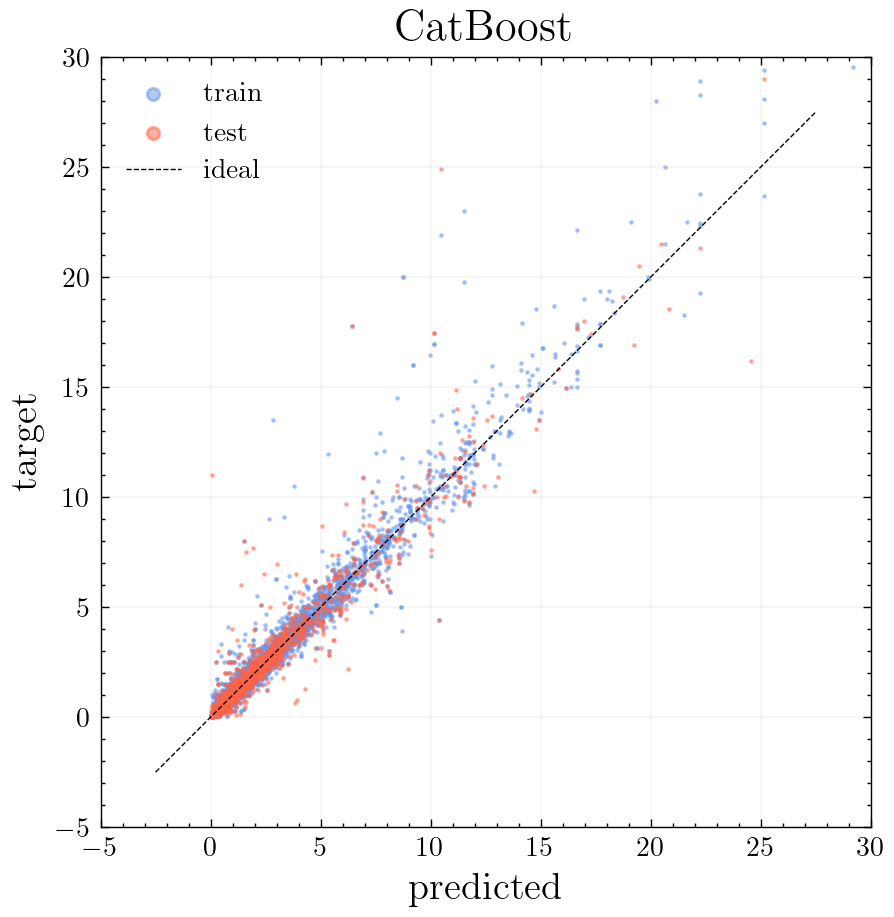

In [82]:
    # predictions visualization in matplotlib
lables_fs = 16
ticks_fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_lim = -5
up_lim = 30  # some points 3-5 are out of the plot limits - outliers
delta = 2.5

ax.scatter(
    cat_model.predict(X_train),
    y_train, 
    c='cornflowerblue', s=0.5,
    alpha=0.5,
    label='train'
)
ax.scatter(
    preds_test,
    y_test, 
    c='tomato', s=0.5, 
    alpha=0.5,
    label='test'
)

    # ideal predictor
ax.plot(
    [low_lim + delta, up_lim - delta],
    [low_lim + delta, up_lim - delta],
    c='k', linestyle='--', lw=0.50, 
    label='ideal'
)

ax.set_ylabel('target', fontsize=lables_fs - 2)
ax.set_xlabel('predicted', fontsize=lables_fs - 2)
ax.set_title('CatBoost', fontsize=lables_fs)

ax.grid(color='silver', linestyle='-', linewidth=0.1)

ax.set(aspect='equal')
ax.set_xlim([low_lim, up_lim])
ax.set_ylim([low_lim, up_lim])

lgnd = ax.legend(loc='upper left')
for legend_handle in lgnd.legend_handles: legend_handle._sizes = [20]

plt.show()

#### Result

We can see, that the number of outliers is less than were for `RandomForestRegressor` (see results in `optuned-forest.ipynb`)

We can see (not a surprise) that `CatBoost` perfomance is quite better than of `RandomForestRegressor` - let's continue to experiment!

#### Best cars?

We can assume, that cars with predicted price greater than the real one are **the best cars to buy** (according to the model)!

Let's see the top of cars...

In [87]:
data_path_old = '../data/cars_dataset.csv'

In [88]:
cars_df_old = pd.read_csv(data_path_old, index_col=0)
n_rows, _ = cars_df_old.shape
print(f'DF shape: {cars_df_old.shape}')

for column_name in cars_df_old.columns:  # to make all columns names be in lowercase
    cars_df_old = cars_df_old.rename(columns={column_name: column_name.lower()})


cars_df_old['price'] = cars_df_old['price'] / 1e6  # NORMALIZE PRICE TO MILLIONS!

pd.set_option('display.max_columns', None)
cars_df_old.head(3)

DF shape: (22702, 54)


,mark,box,drive_unit,seats,doors,country,engine,volume,color,mileage,price,year,car_type,generation,model,drive,boost_type,cylinder_location,front_brakes,engine_volume,width,front_suspension_type,diameter_cylinder_and_stroke_piston,maximum_power,length,car_class,wheelbase,cylinders,height,fuel,torque,valves_per_cylinder,volume_fuel_tank,rear_track_width,front_track_width,curb_weight_kg,clearance,engine_location,maximum_speed,wheel_size,transmissions,speed_to_100,full_weight,compression_ratio,consumption,engine_power,restyling,release_start_series,end_serial,trunk_volume_max,trunk_volume_min,expense_city,expense_track,consumption_average
0,Mercedes-Benz,automatic,full,5.0,5.0,German,diesel,2.9,black,0.0,12.9028,2020.0,SUV,III (W463) 2018 – now,G-Class,full,turbocharging,in-line,disc ventilated,2925.0,1931.0,"independent, spring",0.0,249.0,4817.0,J,2890.0,6.0,1969.0,diesel,0.0,4.0,75.0,1638.0,1638.0,2453.0,241.0,"front, longitudinal",199.0,265/60/R18,9.0,7.4,3150.0,15.5,9.8,NaN,0.0,2018.0,2020.0,667.0,1941.0,11.5,9.2,9.8
1,Mercedes-Benz,automatic,full,5.0,5.0,German,diesel,2.9,green,0.0,15.7095,2020.0,SUV,III (W463) 2018 – now,G-Class,full,turbocharging,in-line,disc ventilated,2925.0,1931.0,"independent, spring",82.0,330.0,4817.0,J,2890.0,6.0,1969.0,diesel,700.0,4.0,75.0,1638.0,1638.0,2472.0,241.0,"front, longitudinal",210.0,NaN,9.0,6.4,3150.0,15.5,9.6,NaN,0.0,2018.0,2020.0,667.0,1941.0,10.8,8.9,9.6
2,Mercedes-Benz,automatic,full,5.0,5.0,German,gasoline,4.0,black,15500.0,13.8900,2019.0,SUV,III (W463) 2018 – now,G-Class,full,turbocharging,V-type,disc ventilated,3982.0,1931.0,"independent, spring",83.0,422.0,4817.0,J,2890.0,8.0,1969.0,AI-95,610.0,4.0,75.0,1638.0,1638.0,2429.0,241.0,"front, longitudinal",210.0,265/60/R18,9.0,5.9,3150.0,10.5,12.1,direct injection (direct),0.0,2018.0,2020.0,667.0,1941.0,14.1,10.8,12.1


In [83]:
X_copy = X.copy()

In [84]:
_ = replace_nans_cat_features_catboost(cat_cols, X_train, X_copy)
_, _ = normalize_num_features_catboost(num_cols, X_train, X_copy)

In [85]:
preds_all = cat_model.predict(X_copy)

In [89]:
best_cars_df = pd.DataFrame()

best_cars_df['mark'] = cars_df_old['mark']
best_cars_df['model'] = cars_df_old['model']
best_cars_df['year'] = cars_df_old['year']
best_cars_df['mileage'] = cars_df_old['mileage']


best_cars_df['country'] = cars_df_old['country']
best_cars_df['price'] = cars_df_old['price']  # true value

best_cars_df['price_pred'] = preds_all  # predictions

In [90]:
    # difference between true value and predictions
best_cars_df['diff_perc'] = (best_cars_df['price_pred'] - best_cars_df['price']) / best_cars_df['price']

In [91]:
best_cars_df.sort_values(by=['diff_perc'], ascending=False).head(15)

,mark,model,year,mileage,country,price,price_pred,diff_perc
36325,Mazda,626,1992.0,300000.0,Japan,0.020,10.459300,521.965001
23325,Audi,80,1988.0,220000.0,German,0.025,10.517881,419.715233
36379,Audi,100,1983.0,100000.0,German,0.030,10.089320,335.310677
22246,LADA (VAZ),21099,2001.0,147700.0,Russia,0.027,8.880807,327.918782
33657,Moskvich,2140,1979.0,80000.0,Russia,0.023,7.232989,313.477803
36376,Audi,100,1983.0,300000.0,German,0.033,9.812376,296.344726
24190,Moskvich,2141,1994.0,100000.0,Russia,0.030,8.826546,293.218193
23951,Moskvich,2141,1994.0,100000.0,Russia,0.030,8.826546,293.218193
36632,Ford,Scorpio,1988.0,150050.0,USA,0.030,8.648688,287.289607
16180,LADA (VAZ),2112,2003.0,168000.0,Russia,0.029,8.061459,276.981346


#### Feature importance

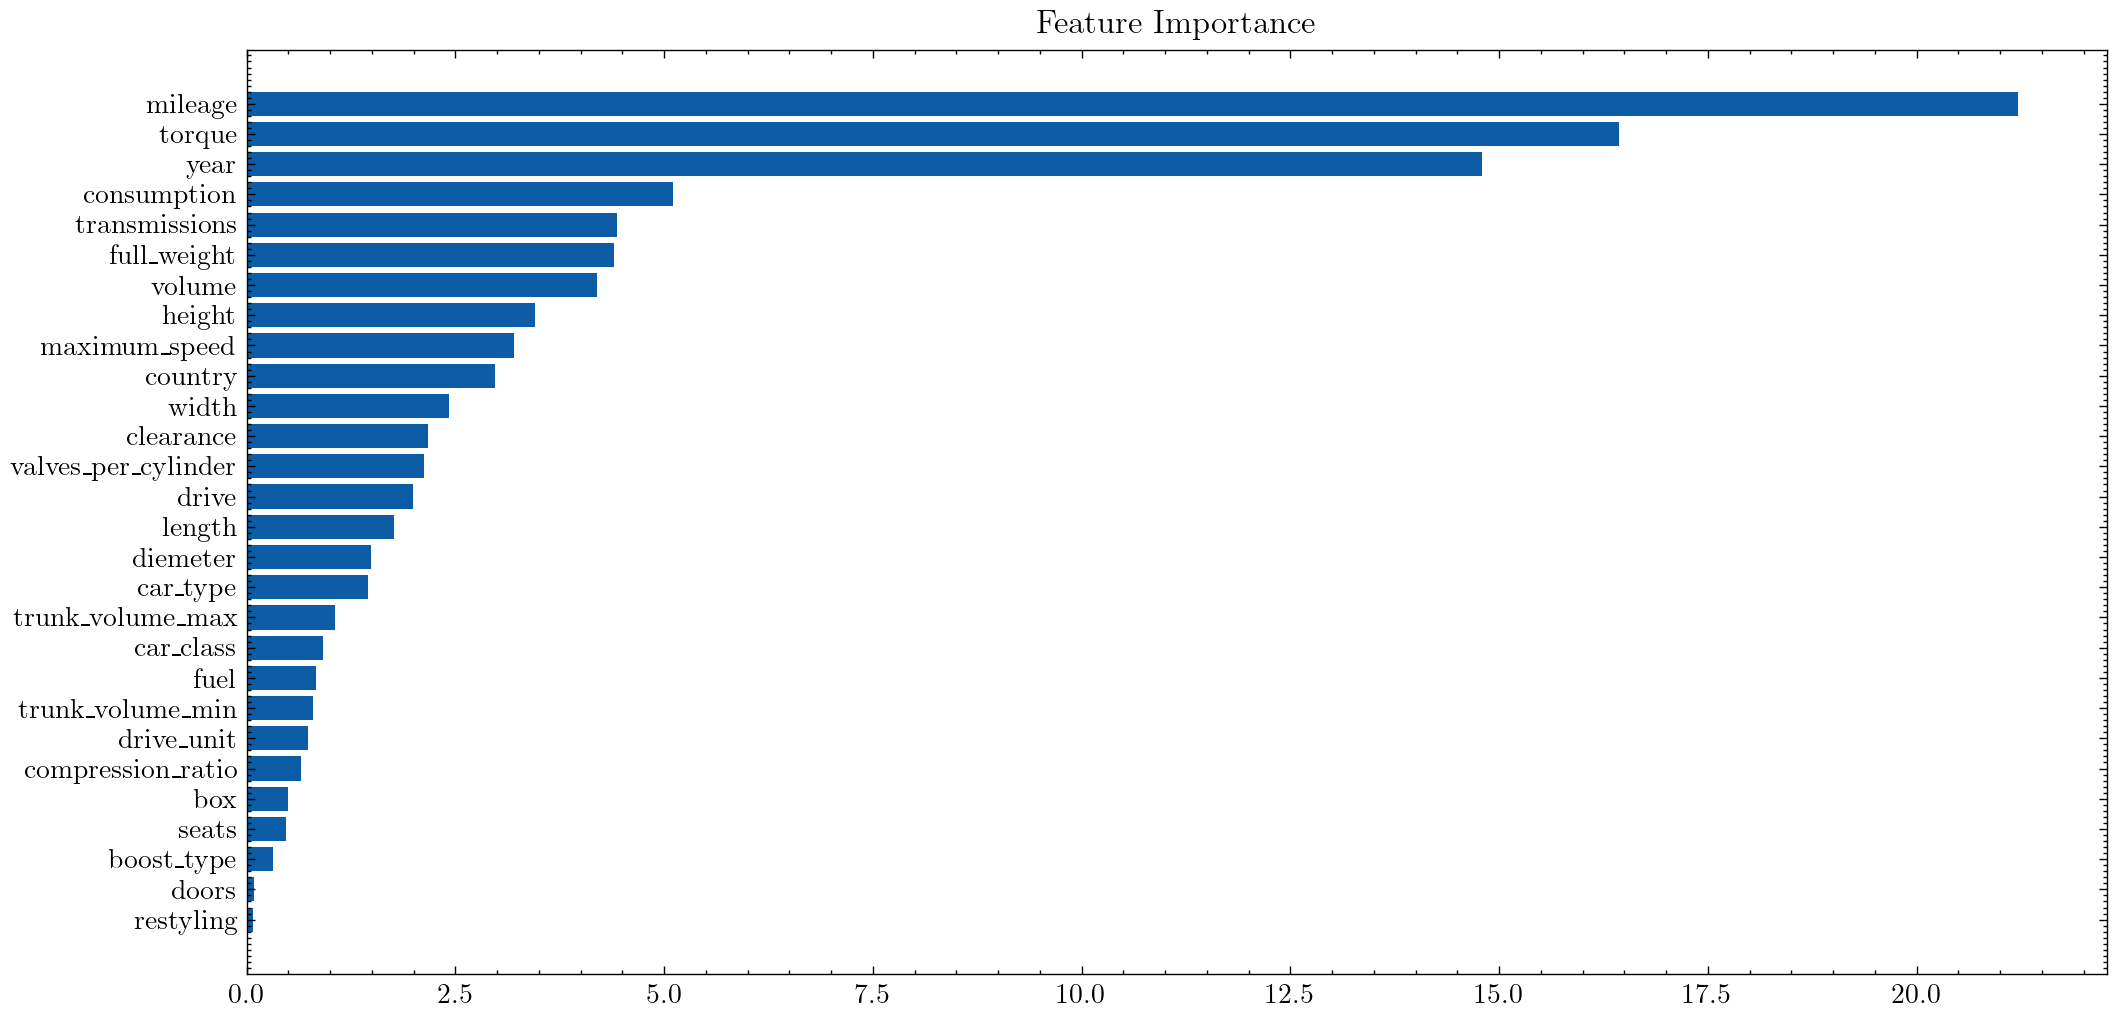

In [84]:
feature_importance_cat = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance_cat)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance_cat[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

Feature importance **looks logical**: obtained `top-3` of features plays huge role in a price price formation (_according to the life experience_) 

1. `mileage`
    - #4 for `RandomForestRegressor`
2. `torque` ~ `maximum_power`
    - #1 for `RandomForestRegressor`
3. `year`
    - #2 for `RandomForestRegressor`

4. `consumption`
5. `transmissions`
    - #3 for `RandomForestRegressor`

Two of them also from top-3 of the most important features for `RandomForestRegressor`!

**P.S.** According to EDA: `torque` ~ `maximum_power` ~ `engine_volume` ~ `cylinders`

### Anomalies searching

In [90]:
cat_cols_1 = ['box', 'drive_unit', 'drive', 'boost_type', 'car_class', 'fuel']  # no more than 9 options - binary_encoder
cat_cols_2 = ['country', 'car_type']  # more ore equal to 17 options

In [40]:
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # but ther is no NaN's in numerical data in our case
        ("scaler", StandardScaler())]
)

cat_transformer_1 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', ce.BinaryEncoder())
    ]
)

cat_transformer_2 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', ce.HashingEncoder(n_components=4))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_1', cat_transformer_1, cat_cols_1),
        ('cat_2', cat_transformer_2, cat_cols_2)
    ]
)

In [41]:
X_trans = X.copy()
    # transform categorical features
X_trans = preprocessor.fit_transform(X_trans)

In [43]:
clf_anomalies = IsolationForest(random_state=2023).fit(X_trans)

In [44]:
anomaly_or_not = clf_anomalies.predict(X_trans)

anomalies_ids = np.where(anomaly_or_not == -1)[0]
normal_ids = np.where(anomaly_or_not == 1)[0]

print(f'Number of anomaly points: {len(anomalies_ids)}')

Number of anomaly points: 6324


In [45]:
anomalies_ids

array([   52,    53,    54, ..., 22686, 22689, 22690])

#### Anomalies visualization

In [46]:
X_trans_cat = X.copy()

for num_column_name in num_cols:
    X_trans_cat[num_column_name] = (X_trans_cat[num_column_name] - num_train_means[num_column_name]) / num_train_vars[num_column_name]

for cat_column_name in cat_cols:    
    X_trans_cat[cat_column_name].fillna(cat_train_most_freq[cat_column_name], inplace=True)

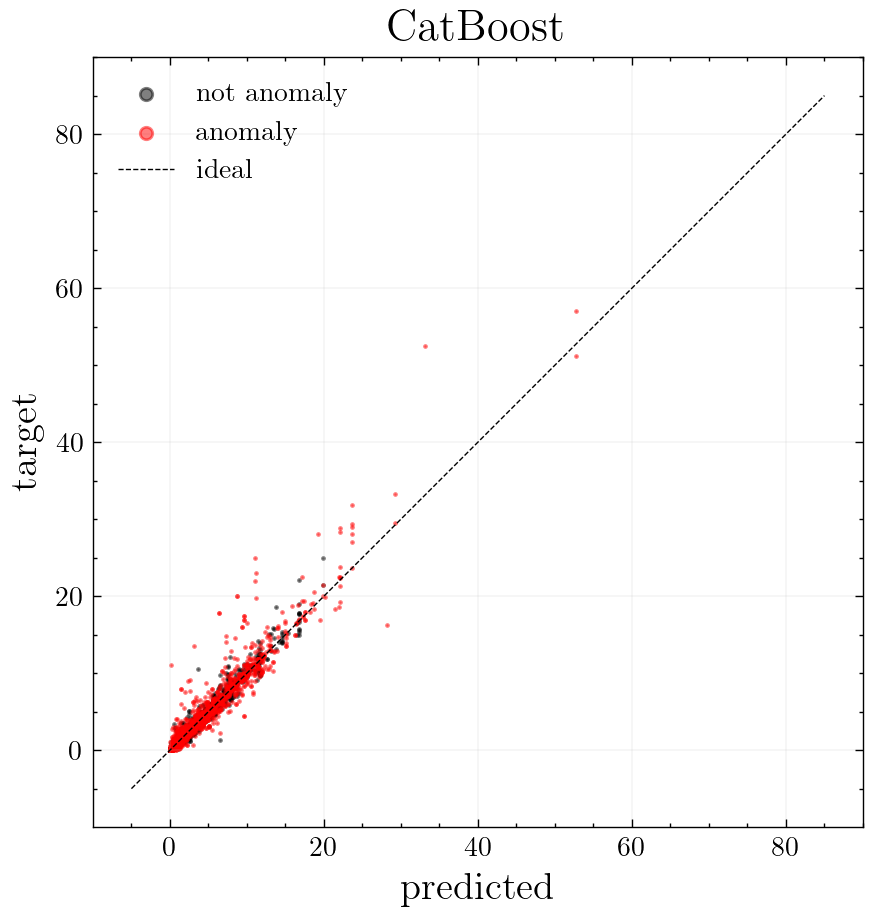

In [47]:
    # predictions visualization in matplotlib
lables_fs = 16
ticks_fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_lim = -10
up_lim = 90
delta = 5

ax.scatter(
    cat_model.predict(X_trans_cat.iloc[normal_ids]),
    y.iloc[normal_ids], 
    c='k', s=0.5,
    alpha=0.5,
    label='not anomaly'
)
ax.scatter(
    cat_model.predict(X_trans_cat.iloc[anomalies_ids]),
    y.iloc[anomalies_ids],  
    c='r', s=0.5, 
    alpha=0.5,
    label='anomaly'
)

    # ideal predictor
ax.plot(
    [low_lim + delta, up_lim - delta],
    [low_lim + delta, up_lim - delta],
    c='k', linestyle='--', lw=0.50, 
    label='ideal'
)

ax.set_ylabel('target', fontsize=lables_fs - 2)
ax.set_xlabel('predicted', fontsize=lables_fs - 2)
ax.set_title('CatBoost', fontsize=lables_fs)

ax.grid(color='silver', linestyle='-', linewidth=0.1)

ax.set(aspect='equal')
ax.set_xlim([low_lim, up_lim])
ax.set_ylim([low_lim, up_lim])

lgnd = ax.legend(loc='upper left')
for legend_handle in lgnd.legend_handles: legend_handle._sizes = [20]

plt.show()

#### Result

`IsolationForest` find a lot of anomalies - much more than the number of outliers, that can be seen by eyes. 

**Let's pause** that study and continue trying to predict cars prices  that are less than some `threshold`

### Price treshold for future prediction

We will **throw out** cars from `cars_ds` which `price` is greater than some `threshold`

In [67]:
price_th = 5  # in millions

In [68]:
print(f'Number of cars which price is greater than {price_th}m: {len(y[y > price_th])} (among {len(y)})')

Number of cars which price is greater than 5m: 1007 (among 22702)


In [69]:
X_th = X.iloc[np.where(y <= price_th)[0]]
y_th = y.iloc[np.where(y <= price_th)[0]]

In [70]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(
    X_th, y_th, 
    train_size=TRAIN_SZ, random_state=SEED_SPLITTING
)

In [71]:
print(f'Train size: {len(y_th_train)}')
print(f'Test size:  {len(y_th_test)}')

Train size: 17356
Test size:  4339


In [72]:
num_th_train_means, num_th_train_vars = normalize_num_features_catboost(num_cols, X_th_train, X_th_test)
cat_th_train_most_freq = replace_nans_cat_features_catboost(cat_cols, X_th_train, X_th_test)

### CatBoost

In [73]:
cat_th_model = CatBoostRegressor(
    iterations=5000,
    loss_function='MAE',
    random_seed=78,
    verbose=500,
    cat_features=cat_cols  # categorical features
)

In [74]:
cat_th_model.fit(X_th_train, y_th_train)

0:	learn: 0.6106182	total: 10.6ms	remaining: 53s
500:	learn: 0.1403975	total: 3.1s	remaining: 27.9s
1000:	learn: 0.1187001	total: 6.41s	remaining: 25.6s
1500:	learn: 0.1085028	total: 9.65s	remaining: 22.5s
2000:	learn: 0.1022825	total: 13s	remaining: 19.4s
2500:	learn: 0.0983186	total: 16.2s	remaining: 16.2s
3000:	learn: 0.0955758	total: 19.3s	remaining: 12.9s
3500:	learn: 0.0931446	total: 22.5s	remaining: 9.65s
4000:	learn: 0.0911336	total: 25.8s	remaining: 6.43s
4500:	learn: 0.0897026	total: 29s	remaining: 3.21s
4999:	learn: 0.0882991	total: 32s	remaining: 0us


#### Evaluating the model

In [75]:
preds_th_test = cat_th_model.predict(X_th_test)

In [76]:
mae_th_catboost = np.abs(preds_th_test - y_th_test).mean()  # l1-score (MAE)
mape_th_catboost = (np.abs(preds_th_test - y_th_test) / y_th_test).mean()  # MAPE


print(f'MAE for CatBoost model: {mae_th_catboost:.6f} ({mae_th_catboost * 1e3:.3f}k RUB)')
print(f'MAPE for CatBoost model: {mape_th_catboost * 100:.2f} %')

MAE for CatBoost model: 0.112447 (112.447k RUB)
MAPE for CatBoost model: 16.34 %


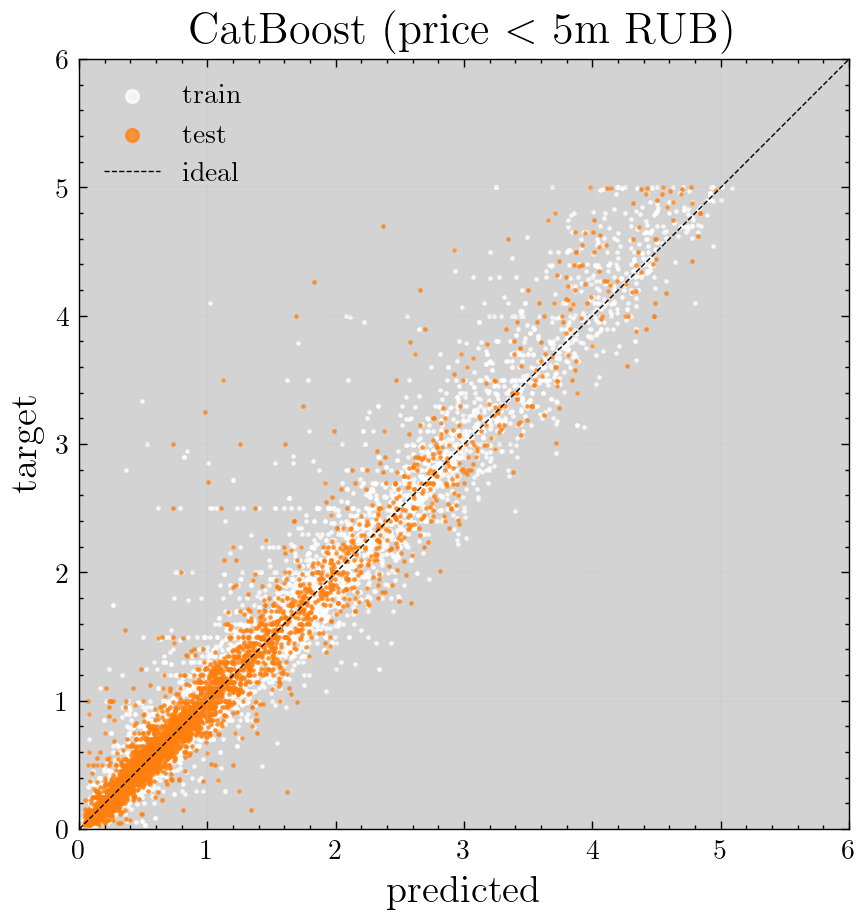

In [89]:
    # predictions visualization in matplotlib
lables_fs = 16
ticks_fs = 12

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_lim = 0
up_lim = 6  # some points 3-5 are out of the plot limits - outliers
delta = 0

ax.scatter(
    cat_th_model.predict(X_th_train),
    y_th_train, 
    c='w', s=0.5,
    alpha=0.75,
    label='train'
)
ax.scatter(
    preds_th_test,
    y_th_test, 
    c='tab:orange', s=0.5, 
    alpha=0.75,
    label='test'
)

    # ideal predictor
ax.plot(
    [low_lim + delta, up_lim - delta],
    [low_lim + delta, up_lim - delta],
    c='k', linestyle='--', lw=0.50, 
    label='ideal'
)

ax.set_ylabel('target', fontsize=lables_fs - 2)
ax.set_xlabel('predicted', fontsize=lables_fs - 2)
ax.set_title(f'CatBoost (price $<$ {price_th}m RUB)', fontsize=lables_fs)

ax.grid(color='silver', linestyle='-', linewidth=0.1)

ax.set(aspect='equal')
ax.set_xlim([low_lim, up_lim])
ax.set_ylim([low_lim, up_lim])

lgnd = ax.legend(loc='upper left')
for legend_handle in lgnd.legend_handles: legend_handle._sizes = [20]

ax.set_facecolor('lightgray')  # gainsboro
plt.show()

#### Result
MAPE metrics remain on the same value, which mans, that dataset _cutting_ does not result in dramatic quality improvement! 